<a href="https://colab.research.google.com/github/peikovakate/colab_files/blob/master/sparsenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2
# !pip install tensorflow==2

In [2]:
from datetime import date

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, Dropout, Activation, Convolution2D, Reshape
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

tf.__version__


'2.0.0'

In [0]:
import tensorflow.keras
tensorflow.keras.backend.clear_session()

## Project in Neural Networks for Data Science applications

(Kateryna Peikova)

# Sparsely Aggregated Convolutional Networks

Link to the paper \
[1] Sparsely Aggregated Convolutional Networks, https://arxiv.org/abs/1801.05895


**Aim of the project:**
1. Implement DenseNet
2. Implement Sparse aggregation from the paper inside the dense block
3. Compare performance of two approaches (DenseNet and SparseNet) on the CIFAR10 dataset.

**Summary of the SparseNet paper:**

The authors came up with new method of output aggregation in deep CNN. Under sparse aggregation they mean skipping some connections inside of the dense block in DenseNet (or Residual blocks in ResNet).

SparseNet will show better or same results with DenseNet that have approximately equal number of parameters. 
![Imagenet results](https://github.com/Lyken17/SparseNet/blob/master/images/imagenet_efficiency.png?raw=true)
Results for ImageNet dataset. [1]

However, it is important to notice that this tendency doesn't work on all datasets according to results presented in the paper. Moreover, sometimes authors compared models that were not close in the number of parameters. 




## Implementation
[2] Densely Connected Convolutional Networks https://arxiv.org/abs/1608.06993

#### Convolution block
Convolution block is the main building block of CNN. 
According to the DenseNet paper [2], it consists of two **composite functions**:
1. **Bottleneck layer**: BN -> ReLU -> Conv 1x1
2. **Convolution layer**: BN -> ReLU -> Conv 3x3 with zero padding

Additionally we insert conditional dropout layer after each convolutional layer.

In [0]:
# convolution block: 1x1 convolution composite block + 3x3 convolution composite block
# l block takes input depth (l-1)*k
def conv_block(x, block_number, sub_block, nb_filter, dropout_rate=None):
    conv_name_base = 'conv_b' + str(block_number) + '-conv_' + str(sub_block)
    relu_name_base = 'conv_b' + str(block_number) + '-relu_' + str(sub_block)
    dropout_name = "conv_b" +str(block_number)+ '-dropout_' + str(sub_block)

    # 1st composite block (funciton)
    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    # batch normalization to train faster
    x = BatchNormalization(name=conv_name_base+'_x1_bn')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate, name=dropout_name+"_x1")(x)

    # 2nd composite block (function)
    # 3x3 Convolution
    x = BatchNormalization(name=conv_name_base+'_x2_bn')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 1, name=conv_name_base+'_x2', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate, name=dropout_name+"_x2")(x)
    return x

#### Dense Block

Dense block is conceptually higher level in the DenseNet architecture and consists of N convolutional blocks implemented above. 

The difference between DenseNet and deep CNN:
Convolutional layers in the dense block are concatenated before every convolutional block. \
As a result we have a very dense connections between convolutional blocks, where the name DenseNet comes from. 


In [0]:
def dense_block(x, block_number, n_layers, n_filters, growth_rate, dropout_rate=None):
    # repeat and concatenate n convolutional blocks
    
    concat_feature_maps = x
    for i in range(n_layers):
        branch = i+1
        x = conv_block(concat_feature_maps, block_number, branch, growth_rate, dropout_rate)
        concat_feature_maps = tf.concat([concat_feature_maps, x], -1)

    n_filters += growth_rate

    return concat_feature_maps, n_filters

#### Sparse Block (Sparse Aggregation)
Here we implement alternative version of the Dense block from SparseNet [1]. 
Idea: every convolutional block has sparse connections with previous blocks. Connections are made with exponential offset layers. So, in the dense block, layer $l$ has $\log_2(l)$ connections with previous layers. 

10: 9, 8, 6, 2

1, 2, 4, 8

In [0]:
def get_sparse_layers(x_list):
    count = len(x_list)
    i = 1
    inputs = []
    while i <= count:
        # insert into beggining
        inputs.insert(0, x_list[count - i])
        # inputs.append(x_list[count - i])
        i *= 2
    return inputs

def sparse_block(x, block_number, n_layers, n_filters, growth_rate, dropout_rate=None):
    x_list = [x]
    channel_list = [n_filters]

    for i in range(n_layers):
        sub_block = i+1
        x = conv_block(x, block_number, sub_block, growth_rate, dropout_rate)
        x_list.append(x)

        fetch_outputs = get_sparse_layers(x_list)
        x = tf.concat(fetch_outputs, axis=-1)

        channel_list.append(growth_rate)

    n_filters = sum(get_sparse_layers(channel_list))

    return x, n_filters



#### Transition block

In [0]:
# layers between dense blocks are called "transition layers"
# to reduce depth of feature maps
def transition_block(x, block_number, nb_filter, compression=1.0, dropout_rate=None):
    conv_name = 'trans' + str(block_number) + "-conv"

    # Convolutional layer
    # Batch normalization to train faster
    x = BatchNormalization(name=conv_name+'_batch_norm')(x)

    # Activation
    relu_name = 'trans' + str(block_number) + "-relu"
    x = Activation('relu', name=relu_name)(x)

    # Convolution
    # bias is not needed because we use batch normalization before convolution
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name, use_bias=False)(x)

    # Dropout layer after each convolutional layer
    dropout_name = "trans" +str(block_number)+ "-dropout"
    if dropout_rate:
        x = Dropout(dropout_rate, name=dropout_name)(x)

    # Pooling layer
    pool_name = 'trans' + str(block_number) +"-pool"
    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name)(x)

    return x

#### Complete Model

In [0]:
def densenet_model(growth_rate=32, nb_filter=64, nb_layers = [6,12,24,16], reduction=0.0, 
             dropout_rate=0.0, classes=16, shape=(32, 32, 3), batch_size=128, sparsenet=False):
  
      # From architecture for ImageNet (Table 1 in the paper)
    # nb_filter = 64
    # nb_layers = [6,12,24,16] # For DenseNet-121
    
    if sparsenet:
      compound_block = sparse_block
    else:
      compound_block = dense_block

    # compute compression factor
    compression = 1.0 - reduction
    nb_dense_block = len(nb_layers)
    
    img_input = Input(shape=shape, name='data')

    x = ZeroPadding2D((1, 1), name='conv1_zeropadding', batch_size=batch_size)(img_input)
    x = Convolution2D(nb_filter, 3, 1, name='conv1', use_bias=False)(x)
    
    block_number = 0
    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        block_number = block_idx+1
        # Add dense block or sparse block
        x, nb_filter = compound_block(x, block_number, nb_layers[block_idx], nb_filter, 
                                      growth_rate, dropout_rate=dropout_rate)

        # Add transition_block
        x = transition_block(x, block_number, nb_filter, compression=compression, 
                             dropout_rate=dropout_rate)
        nb_filter = int(nb_filter * compression)


    final_block = block_number + 1
    # add final dense/sparse block
    # there is no transition here
    x, nb_filter = compound_block(x, final_block, nb_layers[-1], nb_filter, 
                                  growth_rate, dropout_rate=dropout_rate)


    x = BatchNormalization(name='final_conv_bn')(x)
    x = Activation('relu', name='final_relu')(x)
    x = GlobalAveragePooling2D(name='final_pool')(x)
    x = Dense(classes, name='final_dense')(x)
    output = Activation('softmax', name='class_probabilities')(x)
    
    return Model(inputs=img_input, outputs=output, name = "SparseNet" if sparsenet else "DenseNet")


## Analysis


In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

In [0]:
n_layers = [10, 40, 100, 150]
sparse_params = []
dense_params = []
for layers in n_layers:
  model = densenet_model(sparsenet=True, dropout_rate=0.2, nb_layers=[layers], growth_rate=12, classes=10)
  sparse_params.append(model.count_params())
  model = densenet_model(sparsenet=False, dropout_rate=0.2, nb_layers=[layers], growth_rate=12, classes=10)
  dense_params.append(model.count_params())



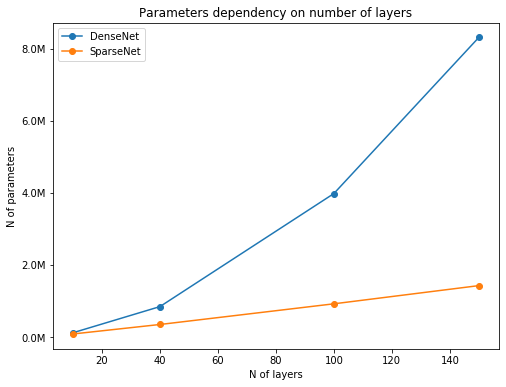

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches((8,6))
ax.yaxis.set_major_formatter(formatter)

plt.plot(n_layers, dense_params, label="DenseNet", marker="o")
plt.plot(n_layers, sparse_params, label="SparseNet",  marker="o")
plt.ylabel("N of parameters")
plt.xlabel("N of layers")
plt.legend()
plt.title("Parameters dependency on number of layers")
plt.show()

## Training


### Data preprocessing

### Training

In [0]:
def compile_model(sparseNet=False, n_layers=[10], k=12):
  model = densenet_model(sparsenet=sparseNet, dropout_rate=0.2, nb_layers=n_layers, growth_rate=k, classes=10, batch_size=128)
  optimizer = Adam(lr=1e-3, amsgrad=True)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  model.count_params()
  return model, model.count_params()

In [0]:
params = {
    "sparse": {
        "layers": [6, 10, 20],
        "growth_rate": [12, 12, 12],
        "params": [51346, 85082, 169794]
    },
    "dense": {
        "layers": [5, 8, 13],
        "growth_rate": [12, 12, 12],
        "params": [53234, 91082, 166642]
    }
}

In [0]:
def get_file_name(isSparseNet, n_layers, growth_rate):
  model_name = "SparseNet" if isSparseNet else "DenseNet"
  model_file = "{}-{}-k{}.h5".format(model_name, n_layers, growth_rate)
  return model_file

In [0]:
def train(model, model_file, n_epochs=5):
  (trainX, trainY), (testX, testY) = cifar10.load_data()

  trainX = trainX.astype('float32')
  testX = testX.astype('float32')

  cifar_mean = trainX.mean(axis=(0, 1, 2), keepdims=True)
  cifar_std = trainX.std(axis=(0, 1, 2), keepdims=True)

  trainX = (trainX - cifar_mean) / (cifar_std + 1e-8)
  testX = (testX - cifar_mean) / (cifar_std + 1e-8)


  generator = ImageDataGenerator(width_shift_range=5. / 32,
                                height_shift_range=5. / 32,
                                horizontal_flip=True)

  generator.fit(trainX, seed=0)

  # can save here model instance as well if save_weights_only=False
  model_checkpoint = ModelCheckpoint(model_file, monitor="val_accuracy", 
                                    save_best_only=True, verbose=1, 
                                    save_weights_only=False)

  callbacks = [model_checkpoint]

  batch_size=128

  history = model.fit_generator(generator.flow(trainX, trainY, batch_size=batch_size),
                      steps_per_epoch=len(trainX) // batch_size, 
                      epochs=n_epochs,
                      callbacks=callbacks,
                      validation_data=(testX, testY),
                      validation_steps=testX.shape[0] // batch_size, 
                      verbose=1)
  
  return model, history

In [22]:
sparse_history = {
    "models": [],
    "history": [],
    "names": []
}

dense_history = {
    "models": [],
    "history": [],
    "names": []
}

nb_epoch = 20
for i in range(len(params['sparse']['layers'])):
  # SparseNet
  isSparseNet = True
  l = params['sparse']['layers'][i]
  k = params['sparse']['growth_rate'][i]
  name = get_file_name(isSparseNet, l, k)
  print("------------------------------------------------------")
  print("Training", name)

  model, _ = compile_model(isSparseNet, [l], k)
  model, history = train(model, name, nb_epoch)

  sparse_history["models"].append(model)
  sparse_history["history"].append(history)
  sparse_history["names"].append(name)

  # DenseNet
  isSparseNet = False
  l = params['dense']['layers'][i]
  k = params['dense']['growth_rate'][i]
  name = get_file_name(isSparseNet, l, k)
  print("------------------------------------------------------")
  print("Training", name)

  model, _ = compile_model(isSparseNet, [l], k)
  model, history = train(model, name, nb_epoch)

  dense_history["models"].append(model)
  dense_history["history"].append(history)
  dense_history["names"].append(name)

------------------------------------------------------
Training SparseNet-6-k12.h5
Epoch 1/20
389/390 [============================>.] - ETA: 0s - loss: 1.7605 - accuracy: 0.3625
Epoch 00001: val_accuracy improved from -inf to 0.36980, saving model to SparseNet-6-k12.h5
390/390 [==============================] - 97s 249ms/step - loss: 1.7601 - accuracy: 0.3625 - val_loss: 1.7550 - val_accuracy: 0.3698
Epoch 2/20
389/390 [============================>.] - ETA: 0s - loss: 1.4447 - accuracy: 0.4830
Epoch 00002: val_accuracy improved from 0.36980 to 0.39800, saving model to SparseNet-6-k12.h5
390/390 [==============================] - 96s 245ms/step - loss: 1.4443 - accuracy: 0.4831 - val_loss: 2.0645 - val_accuracy: 0.3980
Epoch 3/20
389/390 [============================>.] - ETA: 0s - loss: 1.3261 - accuracy: 0.5238
Epoch 00003: val_accuracy improved from 0.39800 to 0.50280, saving model to SparseNet-6-k12.h5
390/390 [==============================] - 96s 246ms/step - loss: 1.3257 - accu

In [0]:
params = {
    "sparse": {
        "layers": [6, 10, 20, 16, 32],
        "growth_rate": [12, 12, 12, 24, 24, 1027594],
        "params": [51346, 85082, 169794, 490938]
    },
    "dense": {
        "layers": [5, 8, 13, 12, 20],
        "growth_rate": [12, 12, 12, 24, 24],
        "params": [53234, 91082, 166642, 495306, 1015754]
    }
}

In [31]:
nb_epoch = 20
i=3
# SparseNet
isSparseNet = True
l = params['sparse']['layers'][i]
k = params['sparse']['growth_rate'][i]
name = get_file_name(isSparseNet, l, k)
print("------------------------------------------------------")
print("Training", name)

model, _ = compile_model(isSparseNet, [l], k)
model, history = train(model, name, nb_epoch)

sparse_history["models"].append(model)
sparse_history["history"].append(history)
sparse_history["names"].append(name)

# DenseNet
isSparseNet = False
l = params['dense']['layers'][i]
k = params['dense']['growth_rate'][i]
name = get_file_name(isSparseNet, l, k)
print("------------------------------------------------------")
print("Training", name)

model, _ = compile_model(isSparseNet, [l], k)
model, history = train(model, name, nb_epoch)

dense_history["models"].append(model)
dense_history["history"].append(history)
dense_history["names"].append(name)

------------------------------------------------------
Training SparseNet-16-k24.h5
Epoch 1/20
389/390 [============================>.] - ETA: 0s - loss: 1.5532 - accuracy: 0.4298
Epoch 00001: val_accuracy improved from -inf to 0.41550, saving model to SparseNet-16-k24.h5
390/390 [==============================] - 307s 786ms/step - loss: 1.5531 - accuracy: 0.4299 - val_loss: 1.9242 - val_accuracy: 0.4155
Epoch 2/20
389/390 [============================>.] - ETA: 0s - loss: 1.2234 - accuracy: 0.5606
Epoch 00002: val_accuracy did not improve from 0.41550
390/390 [==============================] - 305s 782ms/step - loss: 1.2232 - accuracy: 0.5607 - val_loss: 2.7094 - val_accuracy: 0.3980
Epoch 3/20
389/390 [============================>.] - ETA: 0s - loss: 1.0588 - accuracy: 0.6225
Epoch 00003: val_accuracy improved from 0.41550 to 0.42960, saving model to SparseNet-16-k24.h5
390/390 [==============================] - 305s 782ms/step - loss: 1.0586 - accuracy: 0.6225 - val_loss: 2.8872 - 

In [0]:
import pickle

sparse_val_error = [1 - max(history.history["val_accuracy"]) for history in sparse_history["history"]]
dense_val_error = [1 - max(history.history["val_accuracy"]) for history in dense_history["history"]]

with open('sparse_val_error.pkl', 'wb') as fp:
    pickle.dump(sparse_val_error, fp)

with open('dense_val_error.pkl', 'wb') as fp:
    pickle.dump(dense_val_error, fp)

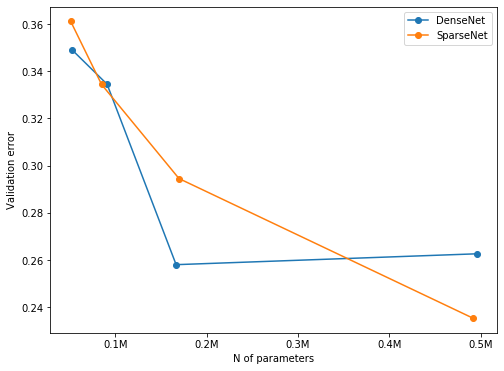

In [51]:
sparse_val_error = [1 - max(history.history["val_accuracy"]) for history in sparse_history["history"]]
dense_val_error = [1 - max(history.history["val_accuracy"]) for history in dense_history["history"]]

dense_params = params["dense"]["params"][:4]
sparse_params = params["sparse"]["params"][:4]

fig, ax = plt.subplots()
fig.set_size_inches((8,6))
ax.xaxis.set_major_formatter(formatter)

plt.plot(dense_params, dense_val_error, label="DenseNet", marker="o")
plt.plot(sparse_params, sparse_val_error, label="SparseNet",  marker="o")


plt.ylabel("Validation error")
plt.xlabel("N of parameters")
plt.legend()
plt.show()